In [1]:
'''Helper'''
import pandas as pd
import numpy as np
from time import time
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import argmax
from textblob import TextBlob
from operator import itemgetter

'''Models'''
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

'''Display'''
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.1f' % x)

DATA_PATH = '/home/jupyter/bi-competitor-analysis/data/'

In [2]:
STOP_WORDS = stopwords.words('english')

### Input data

In [3]:
df = pd.read_csv(DATA_PATH + "twt_main_cleaned.csv")

df.id = df.id.astype(str)

# extract date
df["created_date"] = pd.to_datetime(df.created_at).dt.date
df.created_at = pd.to_datetime(df.created_at)
df.created_date = pd.to_datetime(df.created_date)

print(df.shape)
df.head(1)

(79504, 16)


,created_at,handle,id,text,url,retweet_cnt,like_cnt,reply_cnt,is_rt,pulled_at,num_emojis,hashtags,num_hashtags,clean_text,clean_txt_len,created_date
0,2021-02-27 23:14:05+00:00,nytimes,1365802415371522049,Breaking News: The FDA authorized Johnson &amp...,https://nyti.ms/2Mz4Y9m,6279,16747,880,False,2021-02-28 14:00:30.16545 UTC,0,[],0,breaking news the fda authorized johnson johns...,23,2021-02-27


**3 competitor buckets**
* Business focused competitors - businessinsider, cnnbusiness, foxbusiness, reutersbiz, financialtimes, business
* Current affairs focused competitors - nytimes, wsj, washingtonpost, axios, apbusiness, theeconomist
* Tech/enterpreneur focused - inc, wired, entrepreneur

In [4]:
competitors_df = df[df.handle !='forbes']
print("total competitors shape:", competitors_df.shape)

forbes_df = df[df.handle =='forbes']
print("forbes shape:", forbes_df.shape)

busi_comp_df = df[df.handle.isin(['businessinsider', 'cnnbusiness', 'foxbusiness', 
                                  'reutersbiz', 'financialtimes', 'business'])]
print("business competitors shape:", busi_comp_df.shape)

news_comp_df = df[df.handle.isin(['nytimes', 'wsj', 'washingtonpost', 'axios', 'apbusiness', 'theeconomist'])]
print("news/current affair competitors shape:", news_comp_df.shape)

tech_comp_df = df[df.handle.isin(['inc', 'wired', 'entrepreneur'])]
print("tech competitors shape:", tech_comp_df.shape)

total competitors shape: (71126, 16)
forbes shape: (8378, 16)
business competitors shape: (32464, 16)
news/current affair competitors shape: (31677, 16)
tech competitors shape: (6985, 16)


## Sentiment and Subjectivity analysis 
* To understand Tweeter account(s) in terms of the language that is being used.

    * **Note:** We dont have replies, so sentiment of people's reactions (for brand or topic) cannot be measured

In [5]:
def sentiment_scores(sentence):
  
    sid_obj = SentimentIntensityAnalyzer()
    
    sentiment_dict = sid_obj.polarity_scores(sentence)
    
    return sentiment_dict['compound']

# why 0.05? - thats what they have in their paper - https://github.com/cjhutto/vaderSentiment

def get_sentiment(score):
    '''decide sentiment as positive, negative and neutral'''
    if score >= 0.05 :
        return "Positive"
  
    elif score <= - 0.05 :
        return "Negative"
  
    else :
        return "Neutral"
    
def get_subjectivity(txt):
    return TextBlob(txt).sentiment.subjectivity

In [6]:
start_time = time()

forbes_df["sentiment_score"] = forbes_df.clean_text.apply(sentiment_scores)
forbes_df["sentiment"] = forbes_df.sentiment_score.apply(get_sentiment)
forbes_df["tweet_subjectivity"] = forbes_df.clean_text.apply(get_subjectivity)

print("--- %s minutes ---" % ((time() - start_time)/60)) 

--- 0.9767719586690267 minutes ---


* Compound score = -1 (most extreme negative) and +1 (most extreme positive) sentiment

* **Observation**:
    * positive labels achieved much higher compound score and the majority are higher than 0.5. 
    * negative labels got a very low compound score, with the majority lying below 0.
    * neutral labels are all near 0

<AxesSubplot:title={'center':'sentiment_score'}, xlabel='sentiment'>

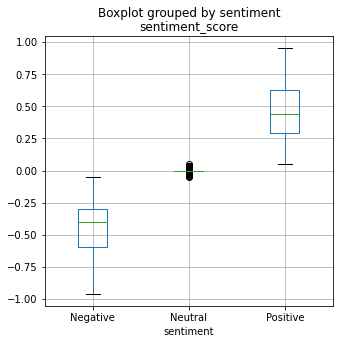

In [7]:
forbes_df.boxplot(column='sentiment_score', by='sentiment', figsize = (5,5))

In [8]:
# this cell takes 7 mins in total cz of lots of rows

# busi competitors' sentiment
start_time = time()

busi_comp_df["sentiment_score"] = busi_comp_df.clean_text.apply(sentiment_scores)
busi_comp_df["sentiment"] = busi_comp_df.sentiment_score.apply(get_sentiment)
busi_comp_df["tweet_subjectivity"] = busi_comp_df.clean_text.apply(get_subjectivity)

print("--- busi %s minutes ---" % ((time() - start_time)/60))

# news competitors' sentiment
start_time = time()

news_comp_df["sentiment_score"] = news_comp_df.clean_text.apply(sentiment_scores)
news_comp_df["sentiment"] = news_comp_df.sentiment_score.apply(get_sentiment)
news_comp_df["tweet_subjectivity"] = news_comp_df.clean_text.apply(get_subjectivity)

print("--- news %s minutes ---" % ((time() - start_time)/60))

# tech competitors' sentiment
start_time = time()

tech_comp_df["sentiment_score"] = tech_comp_df.clean_text.apply(sentiment_scores)
tech_comp_df["sentiment"] = tech_comp_df.sentiment_score.apply(get_sentiment)
tech_comp_df["tweet_subjectivity"] = tech_comp_df.clean_text.apply(get_subjectivity)

print("--- tech %s minutes ---" % ((time() - start_time)/60))

--- busi 3.8034204761187236 minutes ---
--- news 3.7403950293858848 minutes ---
--- tech 0.8089435815811157 minutes ---


**EDA Observations:**
* Forbes uses more positive and neutral language
* News competitors use more polarizing language
* Tech competitors have the most positive language

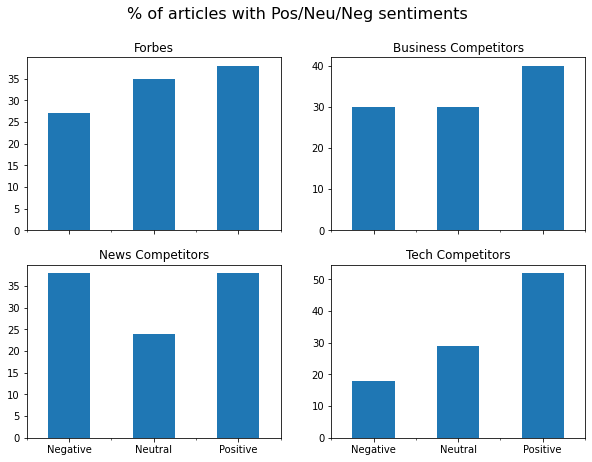

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,7), sharex=True) 
fig.suptitle('% of articles with Pos/Neu/Neg sentiments', fontsize=16)

forbes_df.sentiment.value_counts(normalize=True).mul(100).round().sort_index().plot(kind='bar', 
                                                                                    ax = axes[0][0], 
                                                                                    title="Forbes")

busi_comp_df.sentiment.value_counts(normalize=True).mul(100).round().sort_index().plot(kind='bar', 
                                                                                       ax = axes[0][1], 
                                                                                       title="Business Competitors")

news_comp_df.sentiment.value_counts(normalize=True).mul(100).round().sort_index().plot(kind='bar', 
                                                                                       ax = axes[1][0], 
                                                                                       title="News Competitors")

tech_comp_df.sentiment.value_counts(normalize=True).mul(100).round().sort_index().plot(kind='bar', 
                                                                                       ax = axes[1][1], 
                                                                                       title="Tech Competitors")

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=0)
    
plt.show()

Compare **subjectivity** -  0.0 is very objective and 1.0 is very subjective.
* **EDA Observation:**
    * Mostly everyone's language is objective
    * News folks can be a bit more subjective

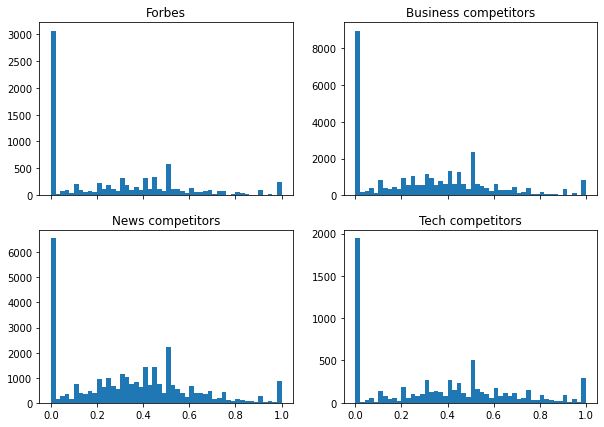

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,7), sharex=True)

n_bins=50
axes[0][0].hist(forbes_df.tweet_subjectivity, 
                bins=n_bins)
axes[0][0].set_title('Forbes')

axes[0][1].hist(busi_comp_df.tweet_subjectivity, 
                bins=n_bins)
axes[0][1].set_title('Business competitors')

axes[1][0].hist(news_comp_df.tweet_subjectivity, 
                bins=n_bins)
axes[1][0].set_title('News competitors')

axes[1][1].hist(tech_comp_df.tweet_subjectivity, 
                bins=n_bins)
axes[1][1].set_title('Tech competitors')

plt.show()

* **Goal** - find some correlation betweein subjectivity, polarity and the engagement 
* USE:
    * Nothing actionable

In [11]:
forbes_df[['retweet_cnt', 'like_cnt', 'reply_cnt', 'sentiment_score', 'tweet_subjectivity']].corr().head(3)

,retweet_cnt,like_cnt,reply_cnt,sentiment_score,tweet_subjectivity
retweet_cnt,1.0,0.9,0.4,0.0,0.0
like_cnt,0.9,1.0,0.4,0.0,0.0
reply_cnt,0.4,0.4,1.0,-0.1,-0.0


In [12]:
busi_comp_df[['retweet_cnt', 'like_cnt', 'reply_cnt', 'sentiment_score', 'tweet_subjectivity']].corr().head(3)

,retweet_cnt,like_cnt,reply_cnt,sentiment_score,tweet_subjectivity
retweet_cnt,1.0,0.5,0.3,-0.0,0.0
like_cnt,0.5,1.0,0.5,-0.0,0.0
reply_cnt,0.3,0.5,1.0,-0.0,-0.0


In [13]:
news_comp_df[['retweet_cnt', 'like_cnt', 'reply_cnt', 'sentiment_score', 'tweet_subjectivity']].corr().head(3)

,retweet_cnt,like_cnt,reply_cnt,sentiment_score,tweet_subjectivity
retweet_cnt,1.0,0.8,0.4,-0.1,0.0
like_cnt,0.8,1.0,0.5,-0.0,0.0
reply_cnt,0.4,0.5,1.0,-0.1,-0.0


In [14]:
tech_comp_df[['retweet_cnt', 'like_cnt', 'reply_cnt', 'sentiment_score', 'tweet_subjectivity']].corr().head(3)

,retweet_cnt,like_cnt,reply_cnt,sentiment_score,tweet_subjectivity
retweet_cnt,1.0,0.2,0.1,-0.0,0.0
like_cnt,0.2,1.0,0.5,-0.0,0.0
reply_cnt,0.1,0.5,1.0,-0.1,0.0


In [15]:
# TODO - bert based sentiment

### Merge twitter main data with entity data
Note - merging will create duplicates of IDs because 1 ID/Tweet can contain multiple entities

In [16]:
twitter_ent = pd.read_csv(DATA_PATH + "twitter_entity_data_05062021.csv", dtype={'id':'str'})

# keep the latest pull info 
twitter_ent = twitter_ent.sort_values('pulled_at', 
                                      ascending=False).drop_duplicates(['id', 'ent_name'])
twitter_ent.reset_index(drop=True, 
                        inplace=True)
print(twitter_ent.shape)
twitter_ent.head()

(129069, 5)


,id,ent_name,ent_type,ent_prob,pulled_at
0,1390267599137775616,Democrats,Organization,0.9,2021-05-06 13:00:30.360048 UTC
1,1389303007423119360,Kroger,Organization,0.8,2021-05-06 13:00:30.360048 UTC
2,1389302626244775936,Powell,Person,0.6,2021-05-06 13:00:30.360048 UTC
3,1390177526077612035,Netflix VP,Organization,0.4,2021-05-06 13:00:30.360048 UTC
4,1389303007423119360,Ohio,Place,1.0,2021-05-06 13:00:30.360048 UTC


In [17]:
col_list = ['id', 'ent_name', 'ent_type', 'ent_prob']

forbes_ent = pd.merge(forbes_df, 
                      twitter_ent[col_list], 
                      on="id", how="left")

busicomp_ent = pd.merge(busi_comp_df, 
                        twitter_ent[col_list], 
                        on="id", how="left")

newscomp_ent = pd.merge(news_comp_df, 
                        twitter_ent[col_list], 
                        on="id", how="left")

techcomp_ent = pd.merge(tech_comp_df, 
                        twitter_ent[col_list],
                        on="id", how="left")

forbes_ent = forbes_ent.fillna('Unknown')
busicomp_ent = busicomp_ent.fillna('Unknown')
newscomp_ent = newscomp_ent.fillna('Unknown')
techcomp_ent = techcomp_ent.fillna('Unknown')

* **Engagement and Sentiment by entity**
    * **EDA Observation**:
        * President Biden - (Forbes avg sentiment 0.1), (news competitors 0.0) - we have used slightly more positive language
        * Trump - (Forbes avg sentiment -0.1), (news competitors -0.0) - we have used slightly more positive language
    * USE:
        * nothing actionable
        
Note: Compound score = -1 (most extreme negative) and +1 (most extreme positive) sentiment

In [18]:
# most popular BTS!
forbes_ent.groupby('ent_name').agg({'retweet_cnt':'sum', 
                                    'like_cnt':'sum', 
                                    'reply_cnt':'sum', 
                                    'sentiment_score':'mean'}).sort_values('like_cnt', ascending=False).head(15)

,retweet_cnt,like_cnt,reply_cnt,sentiment_score
ent_name,,,,
Unknown,41971,155281,12343,0.1
BTS,13127,37963,872,0.1
President Biden,5667,26077,4894,0.1
Biden,5204,23851,4111,0.0
U.S.,6822,22808,2101,0.0
Trump,2764,12093,2786,-0.1
America,2099,8536,1246,0.2
GOP,1710,7512,1872,-0.0
Prince Harry,1233,6721,931,-0.0


In [19]:
busicomp_ent.groupby('ent_name').agg({'retweet_cnt':'sum', 
                                    'like_cnt':'sum', 
                                    'reply_cnt':'sum', 
                                    'sentiment_score':'mean'}).sort_values('like_cnt', ascending=False).head(10)

,retweet_cnt,like_cnt,reply_cnt,sentiment_score
ent_name,,,,
Unknown,120384,236102,19797,0.1
U.S.,33426,68354,9187,0.0
China,24702,43280,6446,0.0
Biden,17488,38844,8205,0.1
Joe Biden,6771,27317,2655,0.1
US,14300,24503,3249,0.0
India,15291,20202,2441,-0.1
Americans,3457,15705,1095,0.1
U.K.,7303,15326,1856,0.0


In [20]:
newscomp_ent.groupby('ent_name').agg({'retweet_cnt':'sum', 
                                    'like_cnt':'sum', 
                                    'reply_cnt':'sum', 
                                    'sentiment_score':'mean'}).sort_values('like_cnt', ascending=False).head(10)

,retweet_cnt,like_cnt,reply_cnt,sentiment_score
ent_name,,,,
Unknown,287080,877795,113640,0.0
U.S.,120757,384366,52783,-0.1
Biden,85499,316212,69246,0.0
President Biden,57324,257668,35766,0.0
Trump,71753,204794,48257,-0.0
George Floyd,44081,164127,16198,-0.5
Derek Chauvin,40977,157722,14913,-0.4
America,26975,90105,14828,-0.0
Republicans,26187,87565,21309,0.0


In [21]:
techcomp_ent.groupby('ent_name').agg({'retweet_cnt':'sum', 
                                    'like_cnt':'sum', 
                                    'reply_cnt':'sum', 
                                    'sentiment_score':'mean'}).sort_values('like_cnt', ascending=False).head(10)

,retweet_cnt,like_cnt,reply_cnt,sentiment_score
ent_name,,,,
Unknown,68617,176157,9211,0.2
Facebook,1571,3772,331,0.1
Ellis Rosen,834,3769,36,0.2
Apple,1072,3573,201,0.1
Bolivia,573,3058,24,0.4
Google,1302,3049,157,0.1
Germany,435,2298,52,-0.1
Amazon,833,2248,212,0.3
Maxim Schulz,362,2026,37,-0.4


### Topic modeling on Forbes tweets

* Why NMF:
    * During research found reviews that NMF is suited for tweets (very short text)
    * LDA relies on probability distribution of words occuring in topics - which is hard to get with such short text
    * Embeddings may be bad

In [22]:
lemmatizer = WordNetLemmatizer()

def process_words(text):
    text = nltk.word_tokenize(text)
    text = [w for w in text if w not in STOP_WORDS]   
    text = [lemmatizer.lemmatize(x) for x in text]
    text = [x for x in text if len(x) > 1]

    # keep only nouns
    is_noun = lambda pos: pos[:2] == 'NN'
    all_nouns = [word for (word, pos) in pos_tag(text) if is_noun(pos)] 
    
    return all_nouns

start_time = time()
forbes_df['processed_noun'] = forbes_df['clean_text'].apply(process_words)

print("--- %s minutes ---" % ((time() - start_time)/60))

--- 0.11925214926401774 minutes ---


--- processing time 1.522511367003123 minutes ---


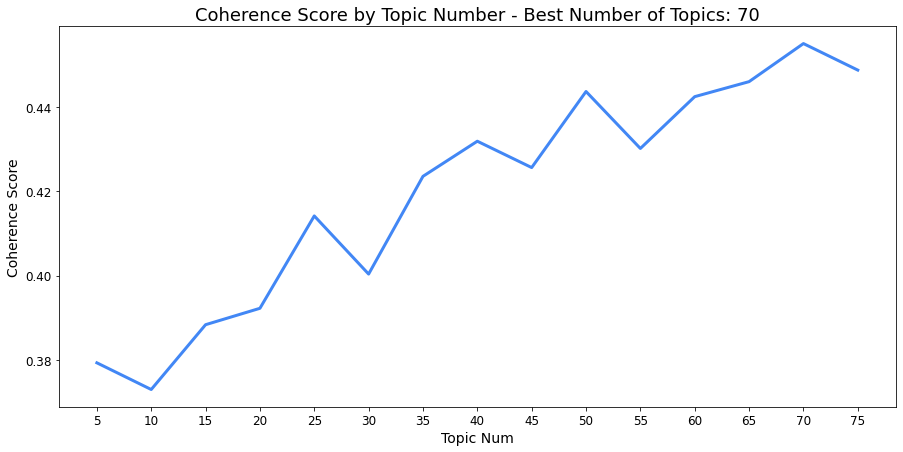

In [23]:
start_time = time()

texts = forbes_df['processed_noun']

dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(no_below=3, no_above=0.85, keep_n=5000)
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers to try
topic_nums = list(np.arange(5, 75 + 1, 5))

coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)

print("--- processing time %s minutes ---" % ((time() - start_time)/60))
plt.show() 

In [24]:
best_num_topics = 50

In [25]:
texts = forbes_df['processed_noun']

# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.95,
    max_features=5000,
    ngram_range=(1, 2),
    preprocessor=' '.join
)

tfidf = tfidf_vectorizer.fit_transform(texts)

# Save the feature names for later to create topic summaries
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# Run the nmf model
nmf = NMF(n_components=best_num_topics, init='nndsvd', max_iter=500, l1_ratio=0.0, solver='cd', alpha=0.0, tol=1e-4,
          random_state=1
).fit(tfidf)

In [26]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(10, 5, figsize=(40, 70), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

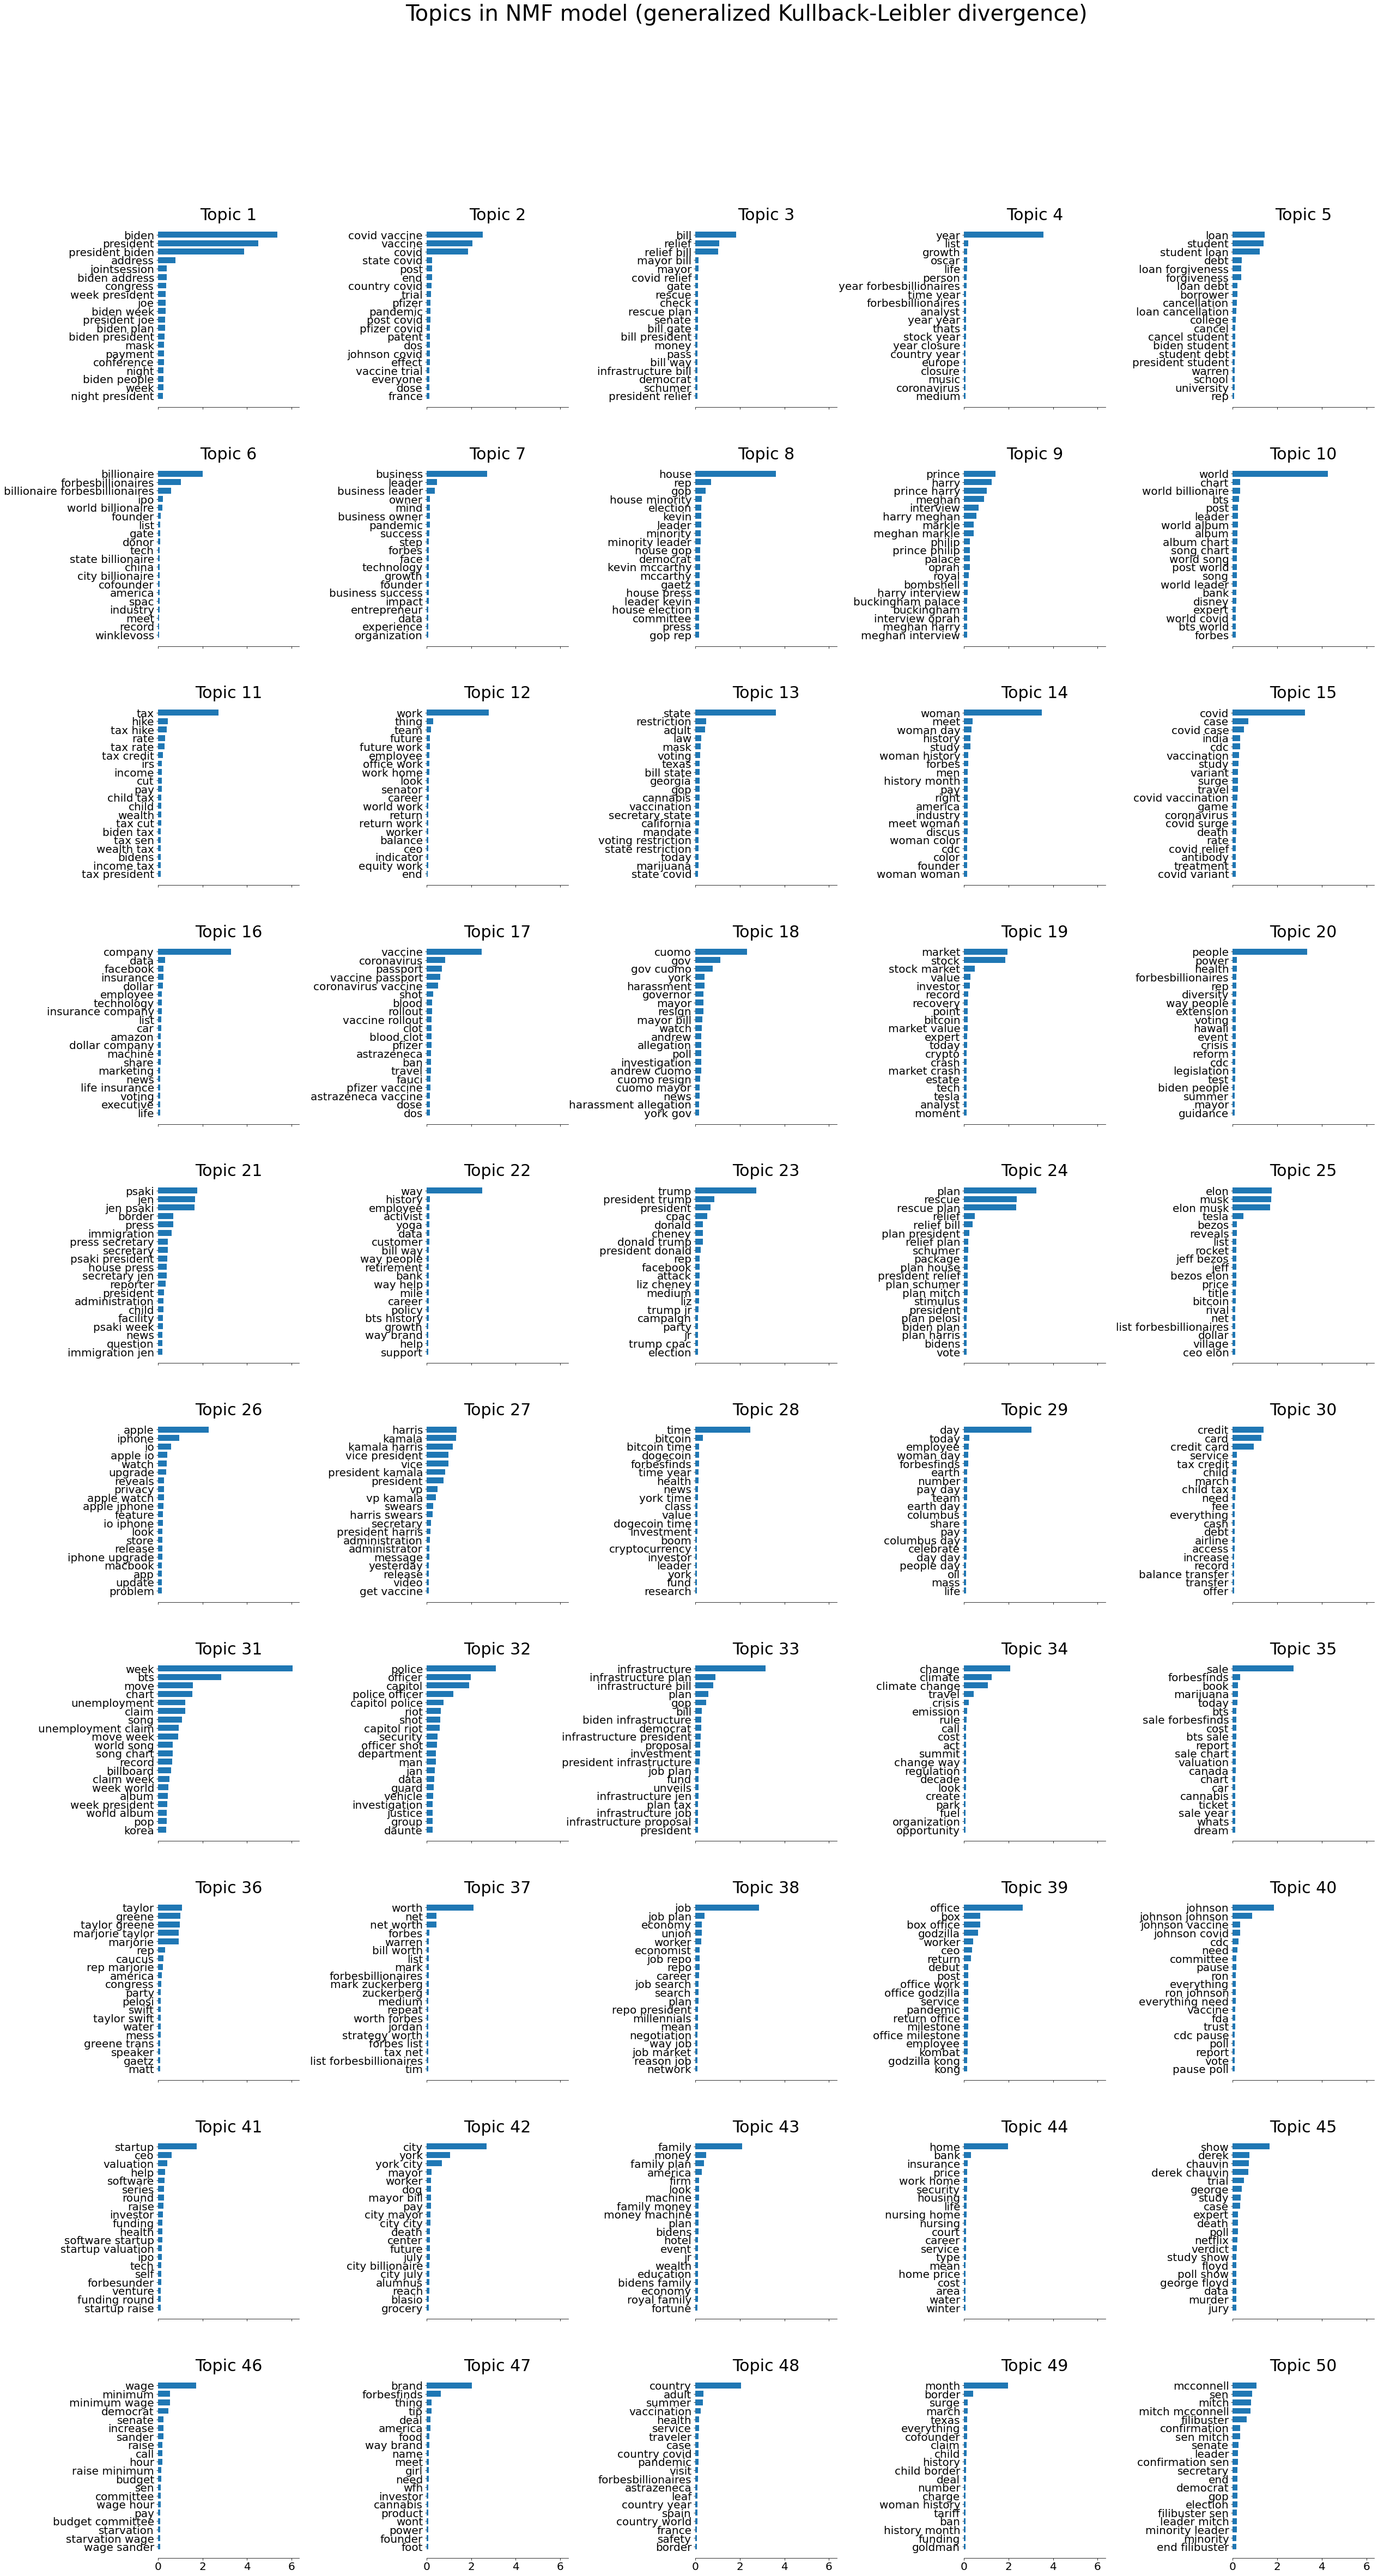

In [27]:
plot_top_words(nmf, tfidf_feature_names, 20,
               'Topics in NMF model (generalized Kullback-Leibler divergence)')

**Topic 1** - president biden<br>
**Topic 2** - covid vaccine<br>
**Topic 3** - senate bill<br>
**Topic 4** - mentioning "year"?<br>
**Topic 5** - student loan<br>
**Topic 6** - billionaires<br>
**Topic 7** - business org<br>
**Topic 8** - congress<br>
**Topic 9** - prince harry<br>
**Topic 10** - mentioning "world"?<br>
**Topic 11** - tax<br>
**Topic 12** - work force<br>
**Topic 13** - mentioning "restrictions"? like on mask, weed, voting<br>
**Topic 14** - women<br>
**Topic 15** - covid cases<br>
**Topic 16** - tech companies<br>
**Topic 17** - covid vaccine (repetition?) <br>
**Topic 18** - cuomo scandal<br>
**Topic 19** - stock market<br>
**Topic 20** - ?<br>
**Topic 21** - jen psaki<br>
**Topic 22** - ? <br>
**Topic 23** - trump<br>
**Topic 24** - rescue plan/bill<br>
**Topic 25** - elon musk<br>
**Topic 26** - apple products<br>
**Topic 27** - kamala harris<br>
**Topic 28** - crypto<br>
**Topic 29** - mentioning "day"?<br>
**Topic 30** - money/credit card<br>
**Topic 31** - mentioning "week"?<br>
**Topic 32** - police<br>
**Topic 33** - infrastructure<br>
**Topic 34** - climate change<br>
**Topic 35** - sale<br>
**Topic 36** - marjorie taylor greene<br>
**Topic 37** - billionaire net worth (repetition?)<br>
**Topic 38** - job market<br>
**Topic 39** - movies<br>
**Topic 40** - jnj<br>
**Topic 41** - startup<br>
**Topic 42** - nyc<br>
**Topic 43** - wealth?<br>
**Topic 44** - mentioning "home"?<br>
**Topic 45** - george floyd<br>
**Topic 46** - minimum wage<br>
**Topic 47** - ?<br>
**Topic 48** - mentioning "country?"<br>
**Topic 49** - border issues?<br>
**Topic 50** - mitch mcconnell<br>

12 out of 50 = 24% are questionable (even a little to highly)

In [28]:
def topic_table(n_top_words, feature_names, model):
    '''
    Get topic number - topic name dataframe
    '''
    topics = {}
    for i, topic_vec in enumerate(model.components_):
        topic_descr = ''
        for fid in topic_vec.argsort()[-1:-n_top_words-1:-1]:
            topic_descr = topic_descr + feature_names[fid] + " "
        topics[i] = topic_descr
    return pd.DataFrame({'topics': topics})

docweights = nmf.transform(tfidf_vectorizer.transform(texts))
# using top 2 words to name the topic
n_top_words = 2

topic_df = topic_table(
    n_top_words, 
    tfidf_feature_names, nmf).T

topic_df = topic_df.T.reset_index()
topic_df.rename(columns={"index":"topic_num"}, inplace=True)
topic_df.head()

,topic_num,topics
0,0,biden president
1,1,covid vaccine vaccine
2,2,bill relief
3,3,year list
4,4,loan student


In [29]:
twt_id = forbes_df.id.tolist()

df_temp = pd.DataFrame({
    'id': twt_id,
    'topic_num': docweights.argmax(axis=1)
})

# Merging to get the topic num 
merged_topic = df_temp.merge(
    topic_df,
    on='topic_num',
    how='left'
)

# Merging with the original df
forbes_topics = pd.merge(
    forbes_df,
    merged_topic,
    on='id',
    how='left'
)
print("Forbes df: ", forbes_topics.shape) 
forbes_topics.topics = forbes_topics.topics.str.strip()
forbes_topics.head(1)

Forbes df:  (8378, 22)


,created_at,handle,id,text,url,retweet_cnt,like_cnt,reply_cnt,is_rt,pulled_at,...,num_hashtags,clean_text,clean_txt_len,created_date,sentiment_score,sentiment,tweet_subjectivity,processed_noun,topic_num,topics
0,2021-04-01 05:50:16+00:00,forbes,1377498528453431296,ATEEZ Discuss The Confidence &amp; Creative Mo...,https://www.forbes.com/sites/jeffbenjamin/2021...,3757,17842,233,False,2021-04-01 11:00:26.610653 UTC,...,0,ateez discuss the confidence creative motivati...,11,2021-04-01,0.7,Positive,0.8,"[discus, confidence, motivation, zero, fever, ...",13,woman meet


### Topics engagement

* USE: 
    * yes - to show on dashboard

In [30]:
eng = forbes_topics.groupby("topics").agg({'retweet_cnt':'sum', 
                                    'like_cnt':'sum', 
                                    'reply_cnt':'sum', 
                                    'sentiment_score':'mean'}).sort_values('like_cnt', ascending=False)
eng.head(15)

,retweet_cnt,like_cnt,reply_cnt,sentiment_score
topics,,,,
week bts,10042,29878,1097,0.1
woman meet,5751,26622,1042,0.1
billionaire forbesbillionaires,6233,22117,1713,0.2
show derek,5763,21684,2874,-0.1
startup ceo,5134,21463,1732,0.1
time bitcoin,5626,21101,1700,0.0
apple iphone,4456,17936,1425,0.0
world chart,5725,17604,699,0.2
prince harry,3078,16579,2213,-0.0


In [31]:
eng.tail(10)

,retweet_cnt,like_cnt,reply_cnt,sentiment_score
topics,,,,
worth net,2016,6570,643,0.3
job job plan,1477,6172,769,0.2
taylor greene,1480,6093,1116,-0.1
city york,1447,5990,614,0.1
plan rescue,1361,5824,811,0.3
credit card,1532,5394,774,0.2
work thing,1379,5373,504,0.1
johnson johnson johnson,1503,4852,569,-0.0
infrastructure infrastructure plan,1126,4726,954,0.1


### Has tone of topics i.e. sentiment/coverage shifted over time?

In [32]:
# make dataframe with number of posts per day per topic

twt_per_day = forbes_topics[["created_date", 
                             "topics"]].copy()
twt_per_day["num_posts"] = 1

twt_per_day = twt_per_day.groupby(["created_date", 
                                   "topics"]).sum().reset_index()
twt_per_day.head(2)

,created_date,topics,num_posts
0,2021-02-24,biden president,5
1,2021-02-24,bill relief,5


In [33]:
# prepare pivot table with number of tweets as values
twt_per_day = twt_per_day.pivot(index='created_date', 
                                columns='topics')

twt_per_day = twt_per_day.fillna(0)

twt_per_day.columns = twt_per_day.columns.get_level_values(1)

twt_per_day

topics,apple iphone,biden president,bill relief,billionaire forbesbillionaires,brand forbesfinds,business leader,change climate,city york,company data,country adult,...,trump president trump,vaccine coronavirus,wage minimum,way history,week bts,woman meet,work thing,world chart,worth net,year list
created_date,,,,,,,,,,,,,,,,,,,,,
2021-02-24,0.0,5.0,5.0,2.0,2.0,5.0,3.0,1.0,4.0,0.0,...,7.0,5.0,0.0,4.0,2.0,2.0,0.0,0.0,0.0,1.0
2021-02-25,4.0,1.0,4.0,4.0,3.0,5.0,1.0,3.0,5.0,1.0,...,7.0,4.0,13.0,6.0,3.0,2.0,2.0,2.0,0.0,2.0
2021-02-26,3.0,2.0,8.0,0.0,5.0,8.0,2.0,1.0,2.0,1.0,...,8.0,4.0,19.0,3.0,2.0,3.0,3.0,4.0,1.0,2.0
2021-02-27,1.0,6.0,2.0,1.0,6.0,9.0,4.0,4.0,1.0,2.0,...,3.0,3.0,5.0,2.0,2.0,1.0,4.0,2.0,1.0,2.0
2021-02-28,0.0,1.0,2.0,0.0,1.0,3.0,2.0,0.0,1.0,2.0,...,12.0,2.0,5.0,1.0,1.0,0.0,3.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-02,12.0,3.0,1.0,2.0,3.0,1.0,1.0,2.0,1.0,3.0,...,1.0,1.0,3.0,5.0,4.0,1.0,3.0,3.0,0.0,3.0
2021-05-03,3.0,3.0,5.0,1.0,3.0,2.0,2.0,1.0,1.0,1.0,...,5.0,4.0,5.0,1.0,1.0,0.0,0.0,4.0,1.0,3.0
2021-05-04,4.0,1.0,1.0,4.0,4.0,4.0,1.0,2.0,4.0,0.0,...,3.0,2.0,3.0,3.0,2.0,1.0,0.0,5.0,2.0,2.0


In [35]:
# for clearly showing on heatmap - choose a subset of topics
topic_lst = ['week bts', 'billionaire forbesbillionaires', 'covid case', 'vaccine coronavirus',  'prince harry', 'biden president', 
                           'apple iphone', 'police officer', 'market stock', 'elon musk', 'time bitcoin', 'taylor greene', 'tax hike',
                           'show derek', 'business leader']

* **Num of tweets posted every day per topic**
    * USE: Compare with competitors on a daily basis to suggest topics to post about?

<AxesSubplot:ylabel='topics'>

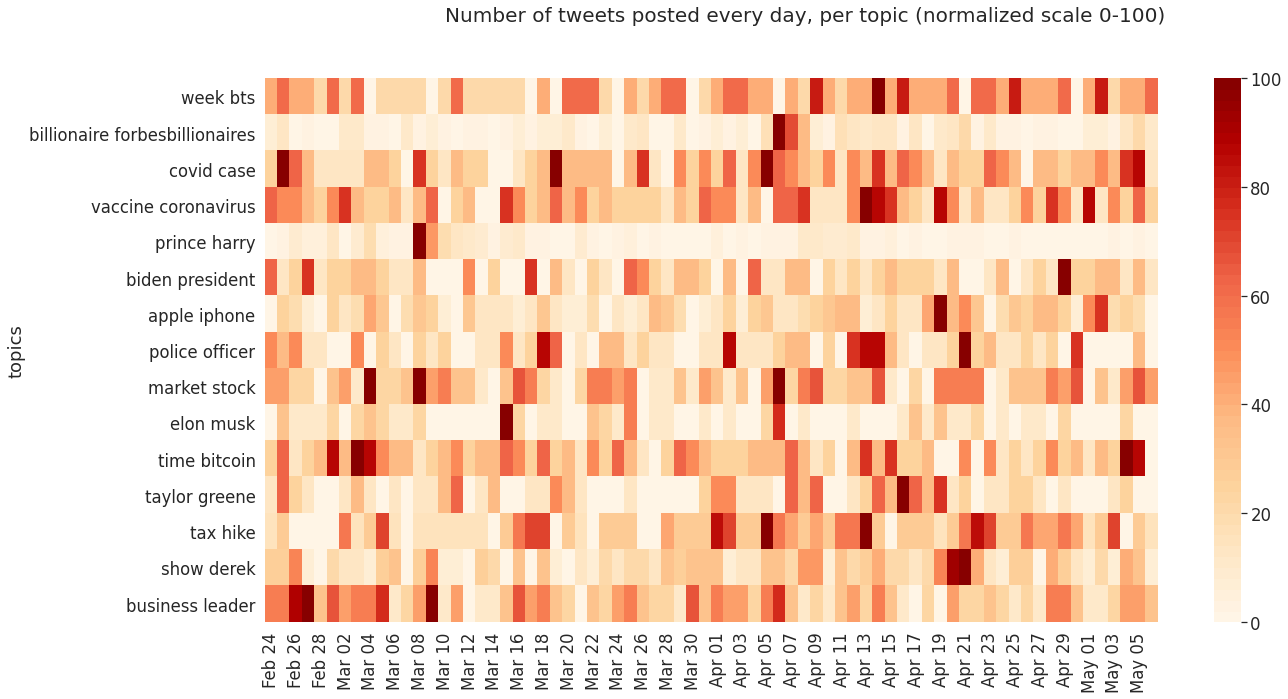

In [36]:
# take subset of topics
twt_per_day = twt_per_day[topic_lst]
df_heatmap = twt_per_day.copy()

# normalize values -- this is to show better color gradient
for col in df_heatmap.columns:
    
    # Normalise the results
    m = max(df_heatmap[col].values)
    df_heatmap[col] = 100 * df_heatmap[col] / m

# extract month-date format
df_heatmap.index = pd.to_datetime(df_heatmap.index.values).strftime('%b %d')
df_heatmap = df_heatmap.T

sns.set(font_scale=1.5)
fig=plt.figure(figsize=(20, 10))
fig.suptitle('Number of tweets posted every day, per topic (normalized scale 0-100)', fontsize=20)

sns.heatmap(df_heatmap, cmap=sns.color_palette("OrRd", 50))

In [43]:
# what does the plot show? - take one example - prince harry interview happened on Mar7. We tweeted quite a bit on that topic around Mar 6-10. Before and after - not so much

pd.DataFrame(twt_per_day["prince harry"]).T

created_date,2021-02-24,2021-02-25,2021-02-26,2021-02-27,2021-02-28,2021-03-01,2021-03-02,2021-03-03,2021-03-04,2021-03-05,...,2021-04-27,2021-04-28,2021-04-29,2021-04-30,2021-05-01,2021-05-02,2021-05-03,2021-05-04,2021-05-05,2021-05-06
prince harry,0.0,1.0,3.0,2.0,2.0,5.0,0.0,3.0,7.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
# TODO: instead of number of posts per tweet, take ratio of engagement by number of posts

* **Day-over-day sentiment change per topic**
    * USE: ?

In [44]:
# specify the metric to be used for heatmap. Can be sentiment_score, retweet_cnt etc.
metric_col ="sentiment_score"

polarity_per_day = forbes_topics[["created_date", 
                              "topics", 
                              metric_col]].copy()

In [45]:
all_topics = forbes_topics["topics"].unique()

In [46]:
# calculate avg. sentiment score per topic per day
polarity_per_day = polarity_per_day.groupby(["created_date", 
                                             "topics"]).agg({"sentiment_score": lambda x: np.mean(list(x))}).reset_index(drop=False)

polarity_per_day.rename(columns={"sentiment_score": "avg_polarity"}, inplace=True)

polarity_per_day.head(2)

,created_date,topics,avg_polarity
0,2021-02-24,biden president,0.3
1,2021-02-24,bill relief,0.5


In [47]:
# manually pivot above df

polarity_per_day = polarity_per_day.groupby("created_date").agg({
                                                                    "topics": lambda x: list(x),
                                                                    "avg_polarity": lambda x: list(x)
                                                                }).reset_index(drop=False)

polarity_per_day["zip"] = polarity_per_day.apply(lambda row: list(zip(row["topics"], 
                                                                      row["avg_polarity"])), axis=1)

for topic_name in all_topics:
    polarity_per_day[topic_name] = polarity_per_day["zip"].apply(lambda x: [elem[1] for elem in x if elem[0] == topic_name])
    polarity_per_day[topic_name] = polarity_per_day[topic_name].apply(lambda x: x[0] if len(x) > 0 else 0)

polarity_per_day.drop(["topics", "avg_polarity", "zip"], axis=1, inplace=True)
polarity_per_day.set_index("created_date", drop=True, inplace=True)

polarity_per_day.head()

,woman meet,world chart,week bts,billionaire forbesbillionaires,business leader,time bitcoin,year list,worth net,show derek,way history,...,mcconnell sen,month border,startup ceo,covid vaccine vaccine,market stock,infrastructure infrastructure plan,psaki jen,wage minimum,tax hike,work thing
created_date,,,,,,,,,,,,,,,,,,,,,
2021-02-24,-0.6,0.0,-0.0,0.0,0.1,0.0,-0.7,0.0,0.2,0.3,...,0.2,0.1,0.2,0.2,0.2,0.0,-0.3,0.0,0.4,0.0
2021-02-25,-0.3,0.0,-0.3,0.1,0.3,0.1,-0.2,0.0,-0.1,0.1,...,0.1,0.2,0.1,0.0,0.1,0.0,-0.1,0.0,-0.2,0.3
2021-02-26,0.2,0.0,0.3,0.0,0.1,-0.6,-0.1,0.2,0.2,-0.5,...,-0.1,0.6,-0.1,0.0,0.3,-0.9,-0.1,0.0,0.0,0.4
2021-02-27,-0.4,-0.0,0.2,0.2,0.2,-0.7,0.0,0.0,0.6,0.4,...,-0.3,0.4,0.0,0.0,-0.0,0.0,-0.6,0.2,0.0,-0.0
2021-02-28,0.0,0.0,0.4,0.0,-0.1,-0.5,0.0,0.0,0.0,0.4,...,0.2,-0.5,0.2,0.0,0.0,0.0,0.0,-0.4,0.0,-0.1


<AxesSubplot:>

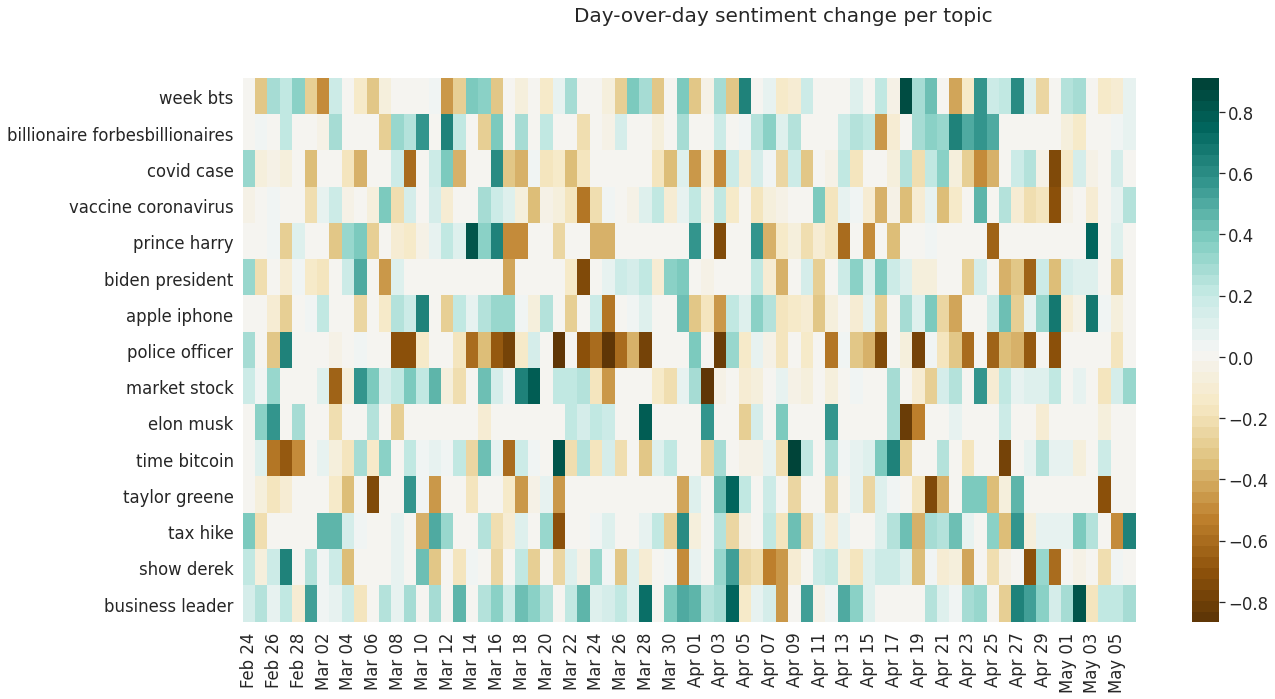

In [48]:
# plot pivoted df

sent_heat = polarity_per_day[topic_lst]
sent_heat.index = pd.to_datetime(sent_heat.index.values).strftime('%b %d')

fig=plt.figure(figsize=(20, 10))
fig.suptitle('Day-over-day sentiment change per topic', fontsize=20)

sns.heatmap(sent_heat.T, cmap=sns.color_palette("BrBG", 50))

In [49]:
# inspect negative tweets for covid cases
insp = forbes_topics[forbes_topics.topics=="covid case"]

print(insp[insp.created_date=="2021-04-24"].text[84])
print()
print(insp[insp.created_date=="2021-04-24"].text[368])
print()
print(insp[insp.created_date=="2021-04-24"].text[556])
print()
print(insp[insp.created_date=="2021-04-24"].text[620])

India Logs Almost 1 Million New Covid Cases In Three Days Amid Deadly Surge https://t.co/qBAJOt5EtO https://t.co/omOyZskmkH

Haunting Images From The Covid-19 Crisis In India https://t.co/T3HFNpJk4N https://t.co/Jvohk8gh9L

The danger of "long Covid" https://t.co/krtLpzEqmU https://t.co/zMaXei9riD

India is experiencing a devastating wave of Covid-19 https://t.co/05tL8GZynO https://t.co/LibdwKtA5n


In [52]:
# inspect negative tweets for market stock
insp = forbes_topics[forbes_topics.topics=="market stock"]

print(insp[insp.created_date=="2021-03-04"].text[2311])
print()
print(insp[insp.created_date=="2021-03-04"].text[6724])
print()
print(insp[insp.created_date=="2021-03-04"].text[2582])

MARKET ALERT: Dow Plunges Nearly 700 Points https://t.co/Qvlob1wcfB https://t.co/3nhXoUZQaX

Market struggles to pare back losses as meme stock volatility continues https://t.co/MsMcr0uwQE https://t.co/aBVXmgxJzp

The Dow plunged nearly 700 points today after Federal Reserve Chairman Jerome Powell’s speech failed to ease investor worries https://t.co/zQ2xWnMo38 https://t.co/aHdGTkAjQ0


In [ ]:
# TODO: % chnage = for product -- and surface that when some sneitment changes syuxddenly

### TODO:
* Compare Forbes topics vs competitor topics